In [ ]:
pip install hyperopt lightgbm

In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,matthews_corrcoef


from xgboost import XGBClassifier
import lightgbm as lgb
# from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import optuna

In [15]:
df = pd.read_csv('../Feature Engineering/EPL_Final_cleaned_features_v2.csv')
df.head(5)

,Temperature,Humidity,WindDirection,Precipitation,WindSpeed,Home_Prv_FTHG,Home_Prv_HS,Home_Prv_HST,Home_Prv_HF,Home_Prv_HC,...,WeatherCode_Clear,WeatherCode_Clouds,WeatherCode_Drizzle,WeatherCode_Fog,WeatherCode_Haze,WeatherCode_Mist,WeatherCode_Rain,WeatherCode_Snow,Time_of_Day_Afternoon,Time_of_Day_Evening
0,1.589044,-0.947690,0.173322,-0.362486,1.677221,0.561811,0.043716,-0.045927,-0.171534,0.002643,...,0,1,0,0,0,0,0,0,1,0
1,1.917548,-0.815443,0.500378,-0.362486,1.280300,1.363757,2.156421,1.555162,-0.443552,1.065042,...,1,0,0,0,0,0,0,0,1,0
2,1.400248,-0.418701,0.816532,-0.362486,0.273563,0.561811,-0.340412,-0.846471,-1.259605,-0.351490,...,0,1,0,0,0,0,0,0,1,0
3,1.811823,-0.683196,0.500378,-0.362486,0.558625,0.561811,-1.300732,-0.446199,2.004609,-1.413890,...,0,0,0,0,0,0,1,0,1,0
4,2.011946,-0.881566,0.500378,-0.362486,0.558625,1.363757,0.811972,2.355707,0.100484,0.710909,...,1,0,0,0,0,0,0,0,1,0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                1072 non-null   float64
 1   Humidity                   1072 non-null   float64
 2   WindDirection              1072 non-null   float64
 3   Precipitation              1072 non-null   float64
 4   WindSpeed                  1072 non-null   float64
 5   Home_Prv_FTHG              1072 non-null   float64
 6   Home_Prv_HS                1072 non-null   float64
 7   Home_Prv_HST               1072 non-null   float64
 8   Home_Prv_HF                1072 non-null   float64
 9   Home_Prv_HC                1072 non-null   float64
 10  Home_Prv_HY                1072 non-null   float64
 11  Home_Prv_HR                1072 non-null   float64
 12  Away_Prv_FTAG              1072 non-null   float64
 13  Away_Prv_AS                1072 non-null   float

In [16]:
train_data = df[df['season'].isin(['2019-2020', '2020-2021'])]
test_data = df[df['season'] == '2021-2022']

### Model with Weather Data:

In [17]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 51), (722,), (350, 51), (350,))

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

def objective(trial, X, y):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Use StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=4)
    cv_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx,], X.iloc[val_idx,]
        y_train, y_val = y.iloc[train_idx,], y.iloc[val_idx,]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
        gbm = lgb.train(param, lgb_train)
        
        preds = gbm.predict(X_val)
        pred_labels = [1 if i > 0.5 else 0 for i in preds]
        
        # Calculate accuracy
        cv_scores.append(accuracy_score(y_val, pred_labels))
    
    # Return mean cross-validation accuracy
    return np.mean(cv_scores)

# Function to perform Bayesian Optimization using Optuna
def perform_bayesian_optimization(X, y):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=50)
    return study.best_trial.params

# Perform Bayesian Optimization and get the best parameters (with weather data)
best_params = perform_bayesian_optimization(X_train, y_train)

# Train the final LightGBM model with the best parameters
model_lgb = lgb.LGBMClassifier(**best_params)
model_lgb.fit(X_train, y_train)

# Predict on the test data (with weather data)
y_pred = model_lgb.predict(X_test)




# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


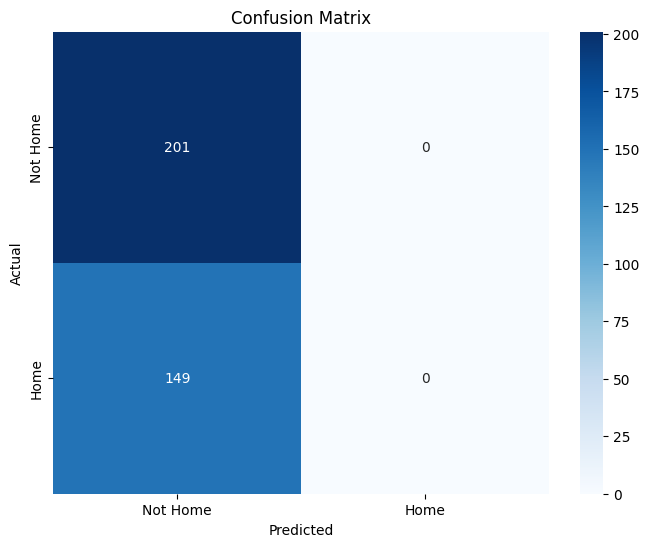

{'max_depth': 8, 'num_leaves': 49, 'learning_rate': 0.002208879265980829, 'min_child_samples': 100, 'subsample': 0.9697604596774718, 'colsample_bytree': 0.9762182341952141}
MCC: 0.0
accuracy: 0.5742857142857143
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       201
           1       0.00      0.00      0.00       149

    accuracy                           0.57       350
   macro avg       0.29      0.50      0.36       350
weighted avg       0.33      0.57      0.42       350



In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [62]:
pd.DataFrame(y_pred,columns=['XGB_y_pred']).to_csv('5.LGVM_y_pred_with_weather.csv')

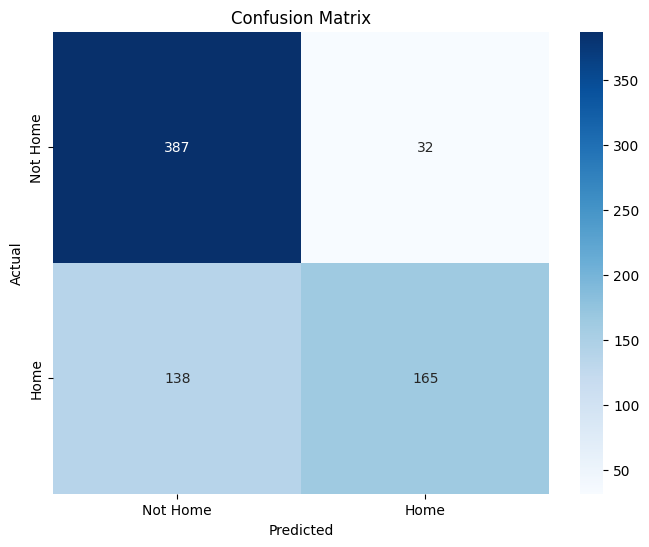

{'max_depth': 5, 'num_leaves': 41, 'learning_rate': 0.028142299557119818, 'min_child_samples': 68, 'subsample': 0.6788019316257772, 'colsample_bytree': 0.7841758673285888}
MCC: 0.518716907201721
accuracy: 0.7645429362880887
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       419
           1       0.84      0.54      0.66       303

    accuracy                           0.76       722
   macro avg       0.79      0.73      0.74       722
weighted avg       0.78      0.76      0.75       722



In [63]:
# Predicting on the train data
y_train_pred = model_lgb.predict(X_train)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_train, y_train_pred)
accuracy = accuracy_score(y_train, y_train_pred)
classification_report_output = classification_report(y_train, y_train_pred)

cm = confusion_matrix(y_train, y_train_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

### Model without Weather Data:

In [64]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 36), (722,), (350, 36), (350,))

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

def objective(trial, X, y):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Use StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=4)
    cv_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx,], X.iloc[val_idx,]
        y_train, y_val = y.iloc[train_idx,], y.iloc[val_idx,]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
        gbm = lgb.train(param, lgb_train)
        
        preds = gbm.predict(X_val)
        pred_labels = [1 if i > 0.5 else 0 for i in preds]
        
        # Calculate accuracy
        cv_scores.append(accuracy_score(y_val, pred_labels))
    
    # Return mean cross-validation accuracy
    return np.mean(cv_scores)

# Function to perform Bayesian Optimization using Optuna
def perform_bayesian_optimization(X, y):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=50)
    return study.best_trial.params

# Perform Bayesian Optimization and get the best parameters (with weather data)
best_params = perform_bayesian_optimization(X_train, y_train)

# Train the final LightGBM model with the best parameters
model_lgb = lgb.LGBMClassifier(**best_params)
model_lgb.fit(X_train, y_train)

# Predict on the test data (with weather data)
y_pred = model_lgb.predict(X_test)




# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


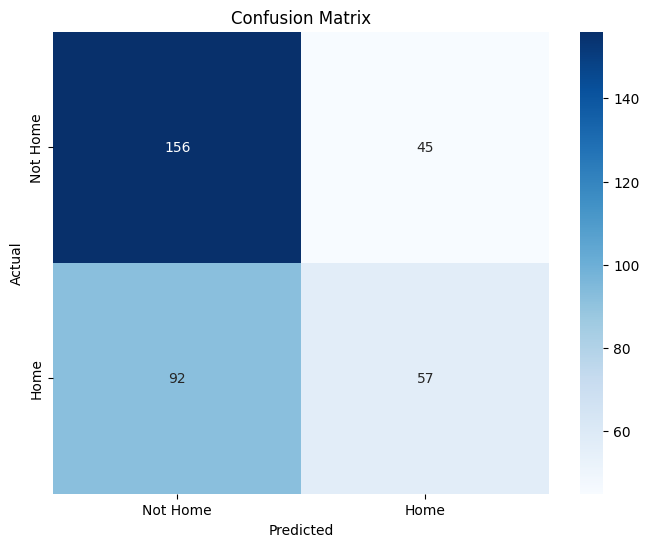

{'max_depth': 6, 'num_leaves': 59, 'learning_rate': 0.026716547334177294, 'min_child_samples': 100, 'subsample': 0.6139856530808834, 'colsample_bytree': 0.9994268741180015}
MCC: 0.17264712185555658
accuracy: 0.6085714285714285
              precision    recall  f1-score   support

           0       0.63      0.78      0.69       201
           1       0.56      0.38      0.45       149

    accuracy                           0.61       350
   macro avg       0.59      0.58      0.57       350
weighted avg       0.60      0.61      0.59       350



In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [67]:
pd.DataFrame(y_pred,columns=['LGVM_y_pred']).to_csv('5.LGVM_y_pred_without_weather.csv')

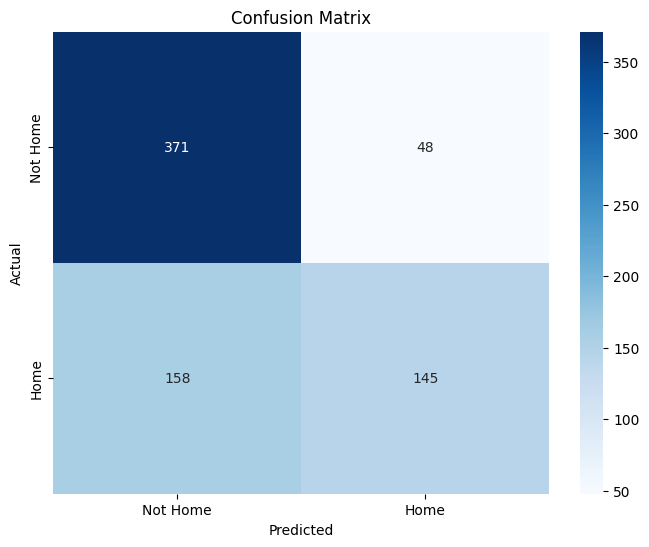

{'max_depth': 6, 'num_leaves': 59, 'learning_rate': 0.026716547334177294, 'min_child_samples': 100, 'subsample': 0.6139856530808834, 'colsample_bytree': 0.9994268741180015}
MCC: 0.40589205499428005
accuracy: 0.7146814404432132
              precision    recall  f1-score   support

           0       0.70      0.89      0.78       419
           1       0.75      0.48      0.58       303

    accuracy                           0.71       722
   macro avg       0.73      0.68      0.68       722
weighted avg       0.72      0.71      0.70       722



In [68]:
# Predicting on the train data
y_train_pred = model_lgb.predict(X_train)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_train, y_train_pred)
accuracy = accuracy_score(y_train, y_train_pred)
classification_report_output = classification_report(y_train, y_train_pred)

cm = confusion_matrix(y_train, y_train_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)